### import modules

In [13]:
import utils.eval_tools as evl
import utils.notebook_utils as nutils

import forge.experiment_tools as fet
from os import path as osp
from attrdict import AttrDict

# Image segmentation on biomedical spectra
*George Hulsey, ECE594N, March 2024*

In this notebook, I explore a number of architectures and their performance on a difficult image segmentation task with very limited data. 

## The dataset

The data is images of prostates with regions annotated which exhibit early signs of prostate cancer. The images are taken using an MRI and then synthetically reconstructed into 2D slices. The measurements come from a handful of subjects; you can access the dataset for free at https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=23691514. 

Below is an image taken from the paper introducing and constructing the dataset, which is cited below. In *(a)* we see a reconstructed histology slice of a prostate. One can see the varied density of the organ and annotated regions where a *real * doctor recongized signs of abnormal growth. The task is to identify these regions. 

<div style="text-align: center;">
<img src="notebook_images/prostate_highlighted_image.jpg" width="800"/>
</div>

>Singanamalli, A., Rusu, M., Sparks, R.E., Shih, N.N.C., Ziober, A., Wang, L.-P., Tomaszewski, J., Rosen, M., Feldman, M. and Madabhushi, A. (2016), *Identifying in vivo DCE MRI markers associated with microvessel architecture and gleason grades of prostate cancer*. J. Magn. Reson. Imaging, 43: 149-158. https://doi.org/10.1002/jmri.24975

With the annotated histology slices, we construct synthetic spectral data as follows. The image is pixelated at some small scale and the image is Fourier-transformed into a discrete set of spectral measurements between 0.05 and 1 mm, in 0.025 mm increments. The result is a set of spectral intensities at a large number of wavelengths associated to each pixel in the histology slice. On general physical grounds, the spectral power density should reflect the spatial density of the sample at the scale of the given wavelength. 

### Data example

The raw spectral data, generated by the process described above, is in csv files. It's loaded by a custom dataset class. Here, we load the image version of the data to observe the ground-truth (an annotated prostate image) alongside the spectral measurements (intensities at differing wavelengths). 

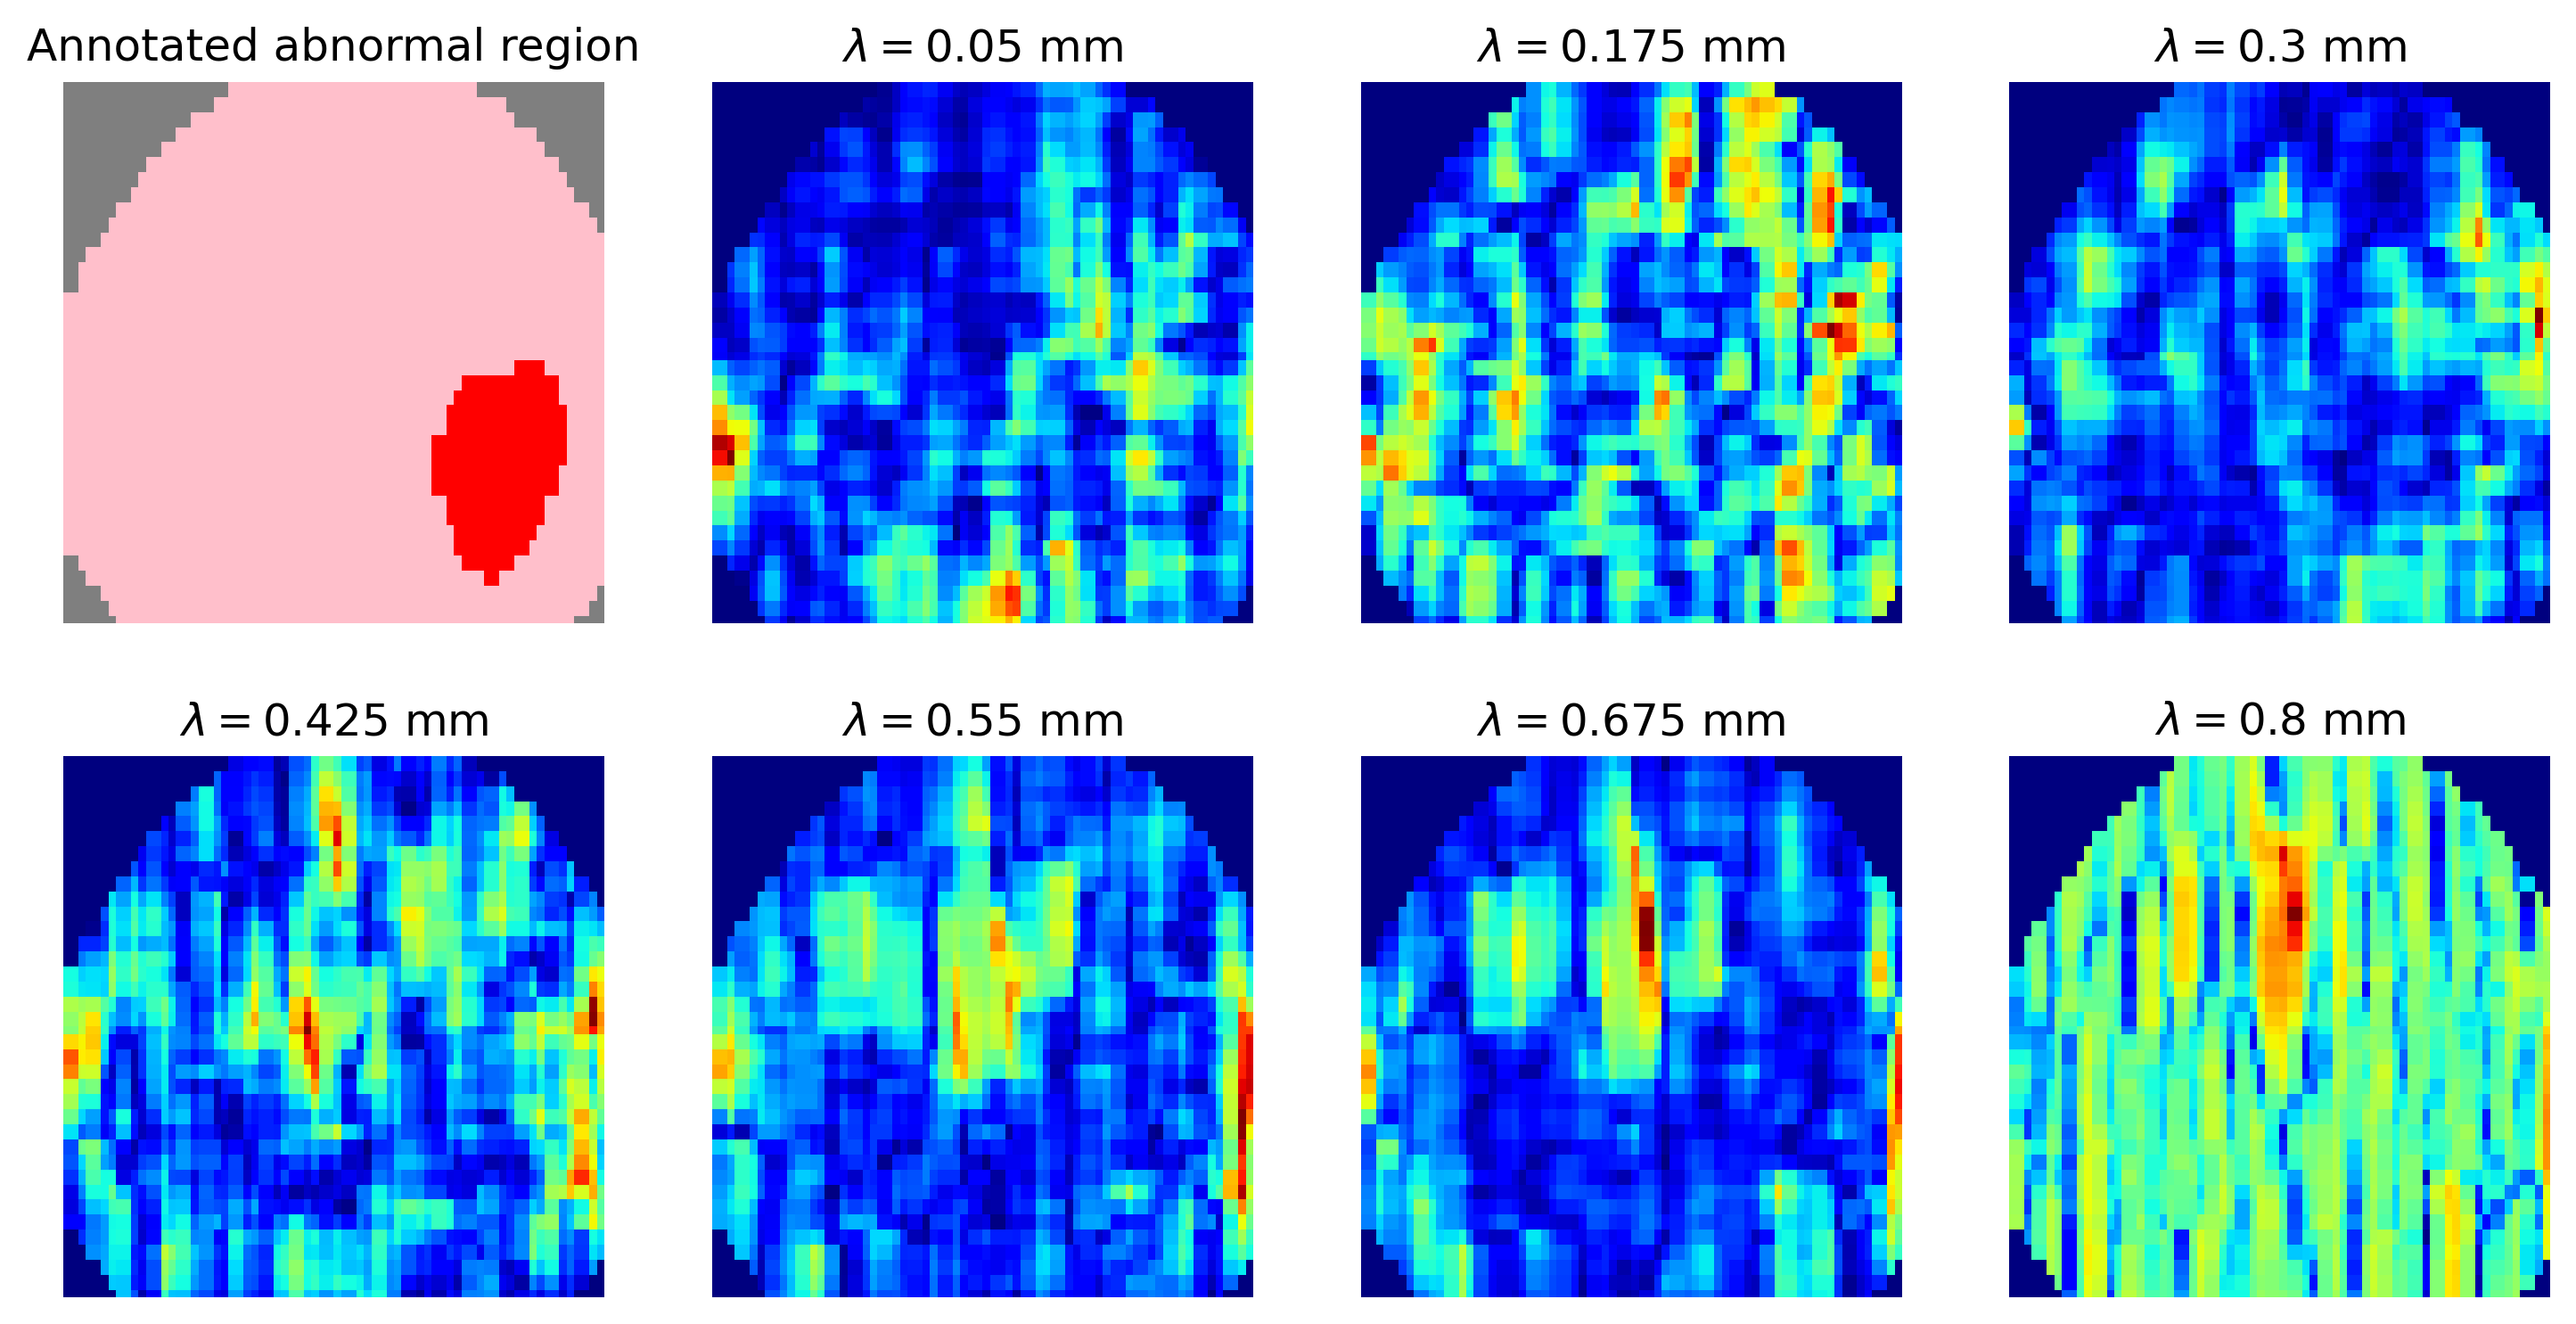

In [2]:
nutils.exampleDataPlot()

### Modeling goal

Given a set of pixels with up to 39 spectral measurements at different wavelengths, can we predict whether the associated pixel displays signs of abnormal growth?

Abstracting away the origin of the data, we are given a set of data: $(x,y,K)$, with $x/y$ pixel coordinates and $K$ a set of spectral measurements. The problem is binary classification of each datapoint into the 0 (non-abnormal) and 1 (abnormal) classes. 

We will see how multiple approaches fare with this problem. While we have pixel image-like data, the data possesess many more channels than grayscale or RGB images. From a modeling perspective, the small size of the dataset also represents a problem. In this notebook, we will evaluate and compare different architectures on this difficult image segmentation task. 

Since the dataset is small, metrics should be cross-validated on different train/test splits. One may also choose to augment the data by transformations to increase the dataset size and improve model performance. 

## Coordinate-free approaches

As a first try we can ignore the spatial relationship between pixels and simply consider the spectral measurements at each site. There are up to 39 such measurements; in all the following we will use them all. Note that we should batch the data according to the image in which the pixel lives so that leakage does not occur between train and test sets.

### *Feed-foward neural network*

To begin, consider just a simple FFNN with 39 input channels and 2 output channels. We import a model and show its architecture below. This model was trained for 50 epochs, and the loss function is the class-weight adjusted cross-entropy. Since the dataset is highly imbalanced, using the class weights is important when building our loss criterion. 

In [2]:
ff_config = AttrDict({'input_size':39,'extra_layer':True})
model,model_name = fet.load('notebook_models/FFNN/basic_feedforward.py',ff_config)
model

Loading 'basic_feedforward' from notebook_models/FFNN/basic_feedforward.py


BasicFFNN(
  (fc1): Linear(in_features=39, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)

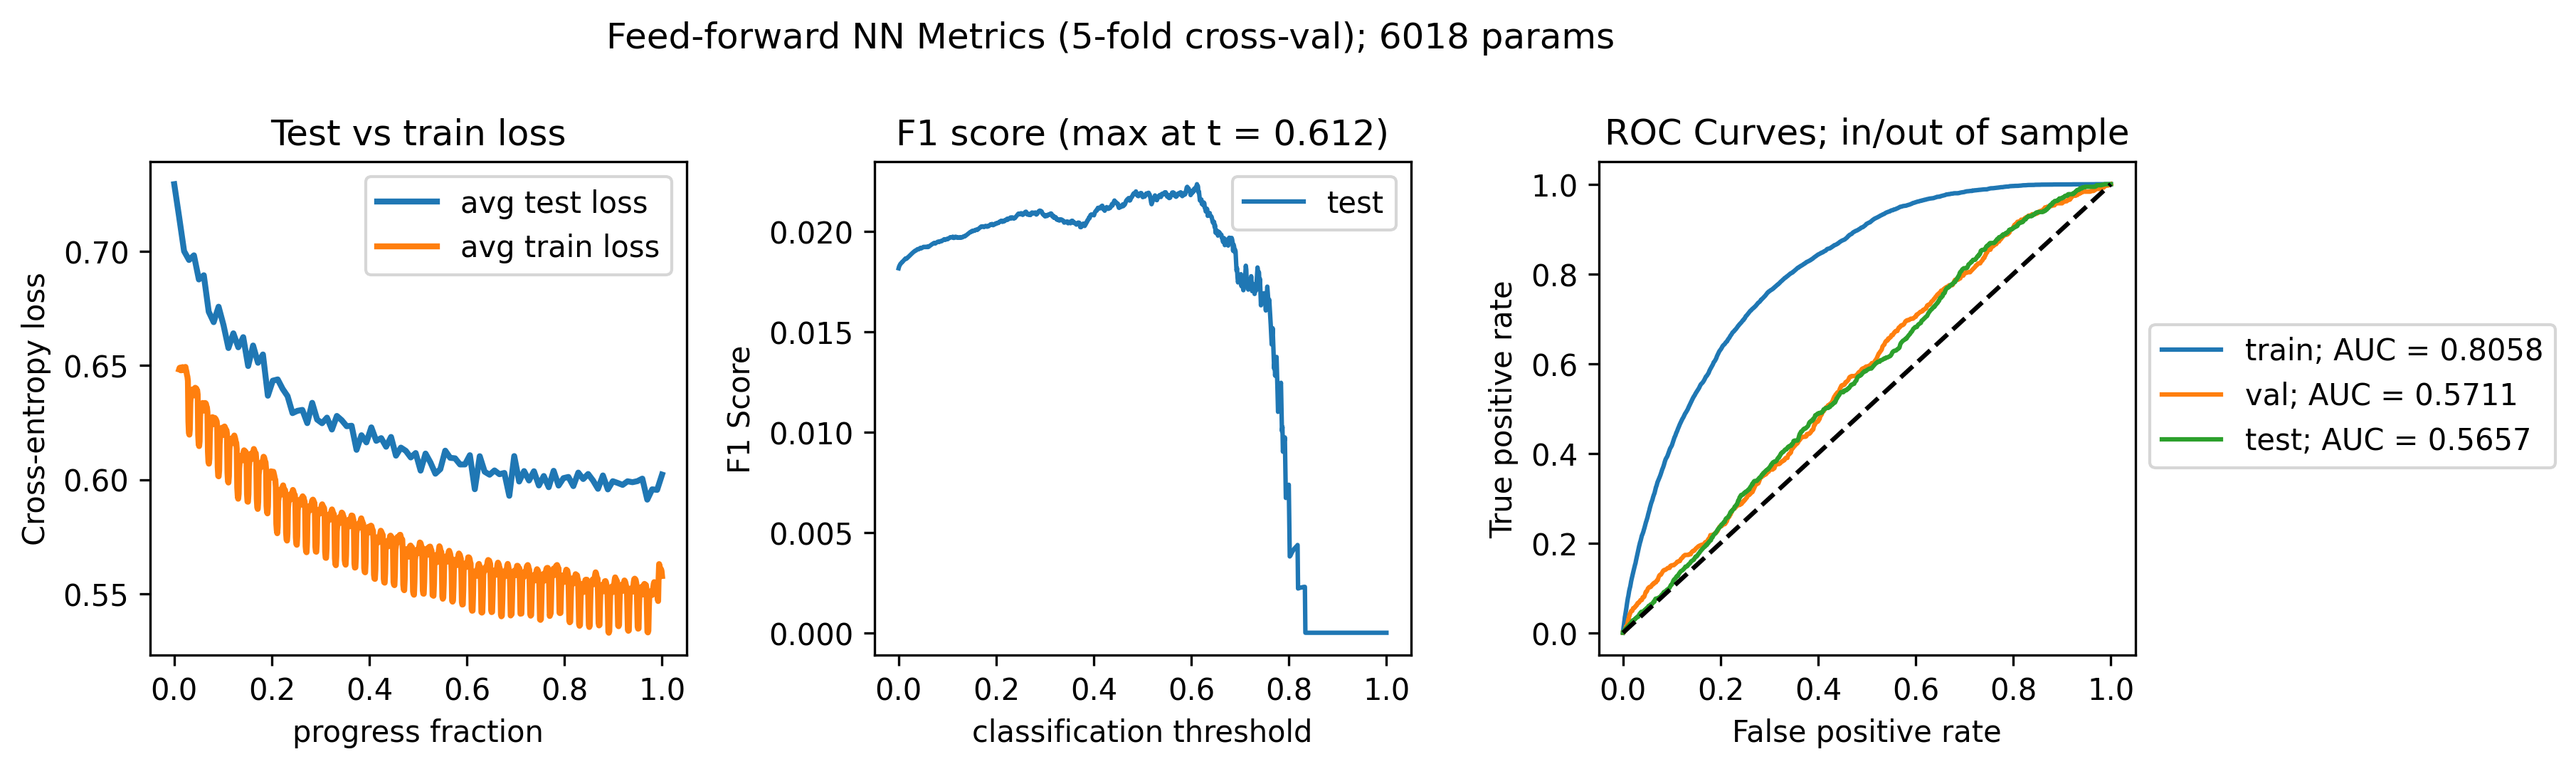

In [3]:
nutils.model_threeplot('FFNN')

In the evaluation above, we can see that the model barely outperforms random guessing (AUC = 0.57). The training and test ROC curves are far apart which suggests also that the model is overfitting. We must assign a classification threshold; for consistency throughout we will do so by maximizing the $F_1$ score: the harmonic mean of precision and recall. Below, we show an example drawn from the test data: the ground truth, the model's probability heatmap, and the corresponding thresholded model predictions.

Loading 'basic_feedforward' from notebook_models/FFNN/basic_feedforward.py


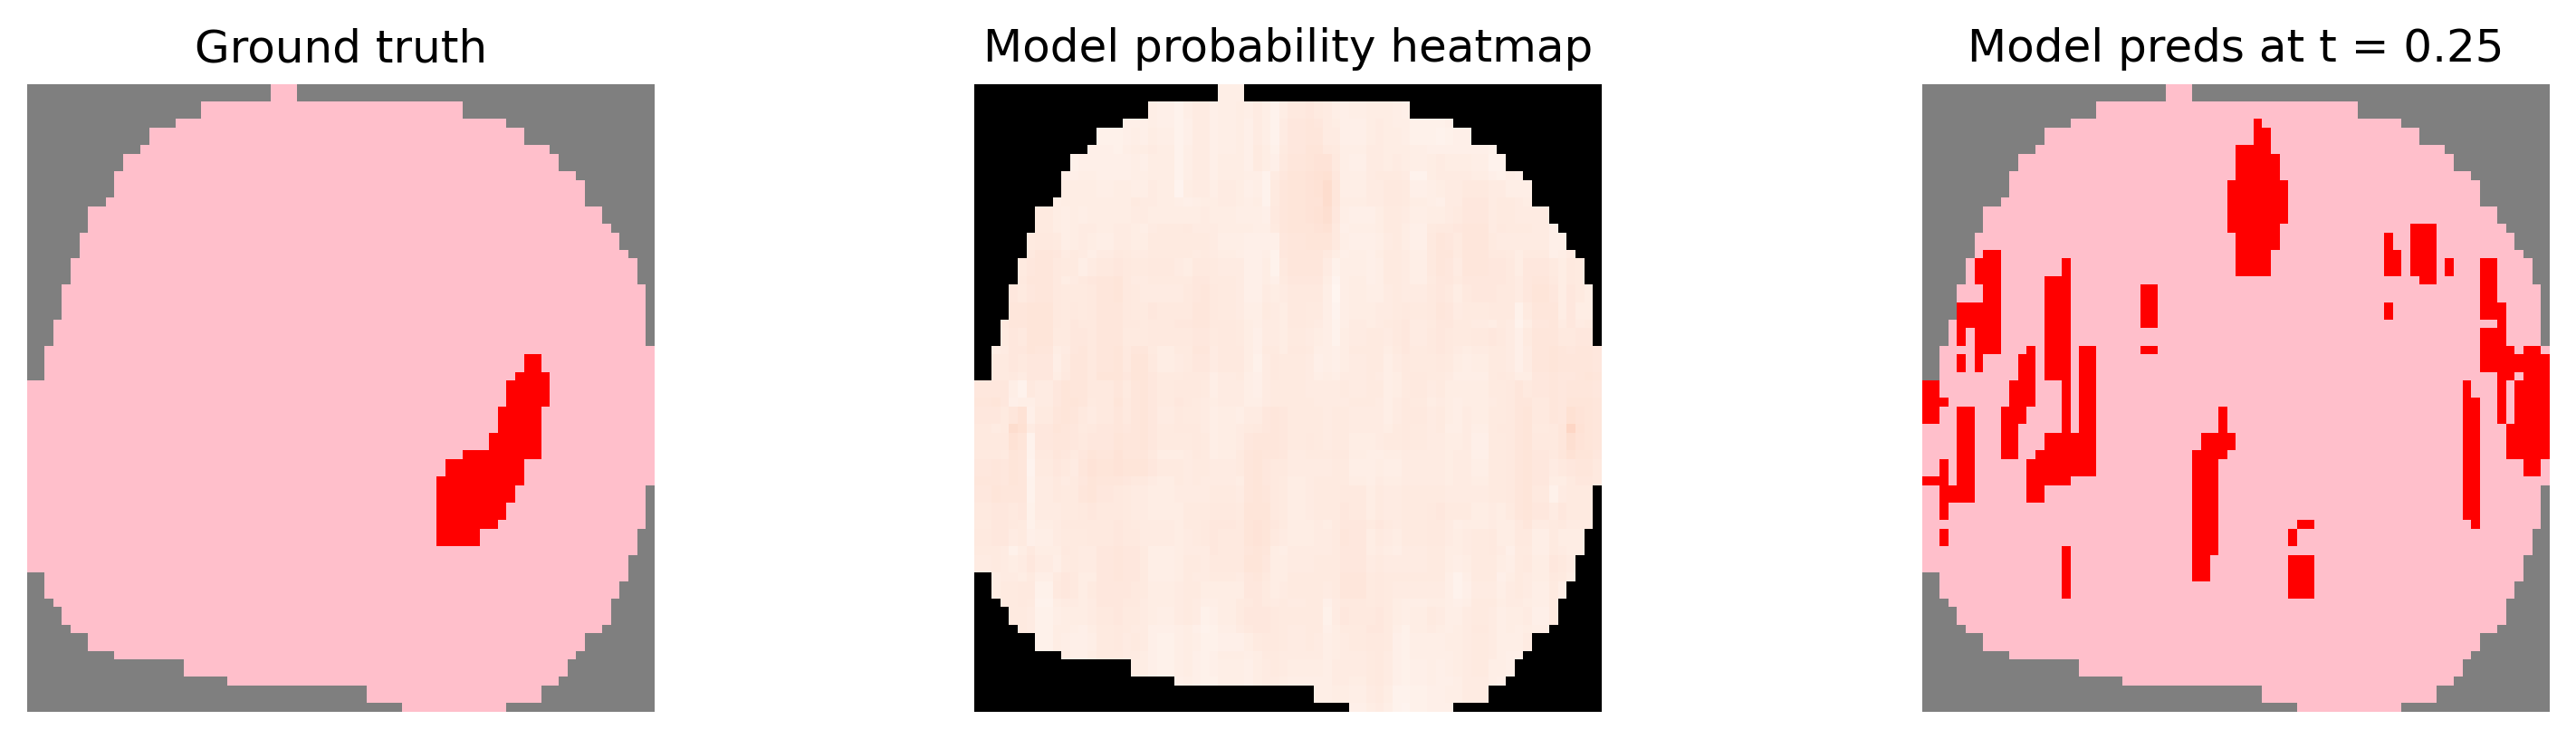

In [4]:
nutils.modelImgCompare('FFNN',0.25)

#### Conclusion: feed-forward neural net

From the metrics and predictions above, we can see that the FFNN is not accurately capturing the details of the annotated regions. This is not surprising as it throws away all the spatial information--and correlations--between neighboring and well-separated pixels. It also does not automatically link the spectral measurements, which are also physically localized in Fourier space. 

### *One-dimensional convolutional network*

Here, we consider a 1-dimensional convolutional network. We slide a filter over the spectral measurements and thereby integrate local (spectral) features from the data. However, this approach is still independent of the pixel coordinates of any given region. We finish the network with a series of fully-connected layers. Since this approach is slow w/o GPU acceleration, this network was trained only for 20 epochs. 

In [5]:
conv1d_config = AttrDict({'dim_hidden':32,'n_classes':2,'kernel_size':3})
model,model_name = fet.load('notebook_models/Conv1D/convNet.py',conv1d_config)
model

Loading 'convNet' from notebook_models/Conv1D/convNet.py


ConvNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(32, 32, kernel_size=(6,), stride=(1,))
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

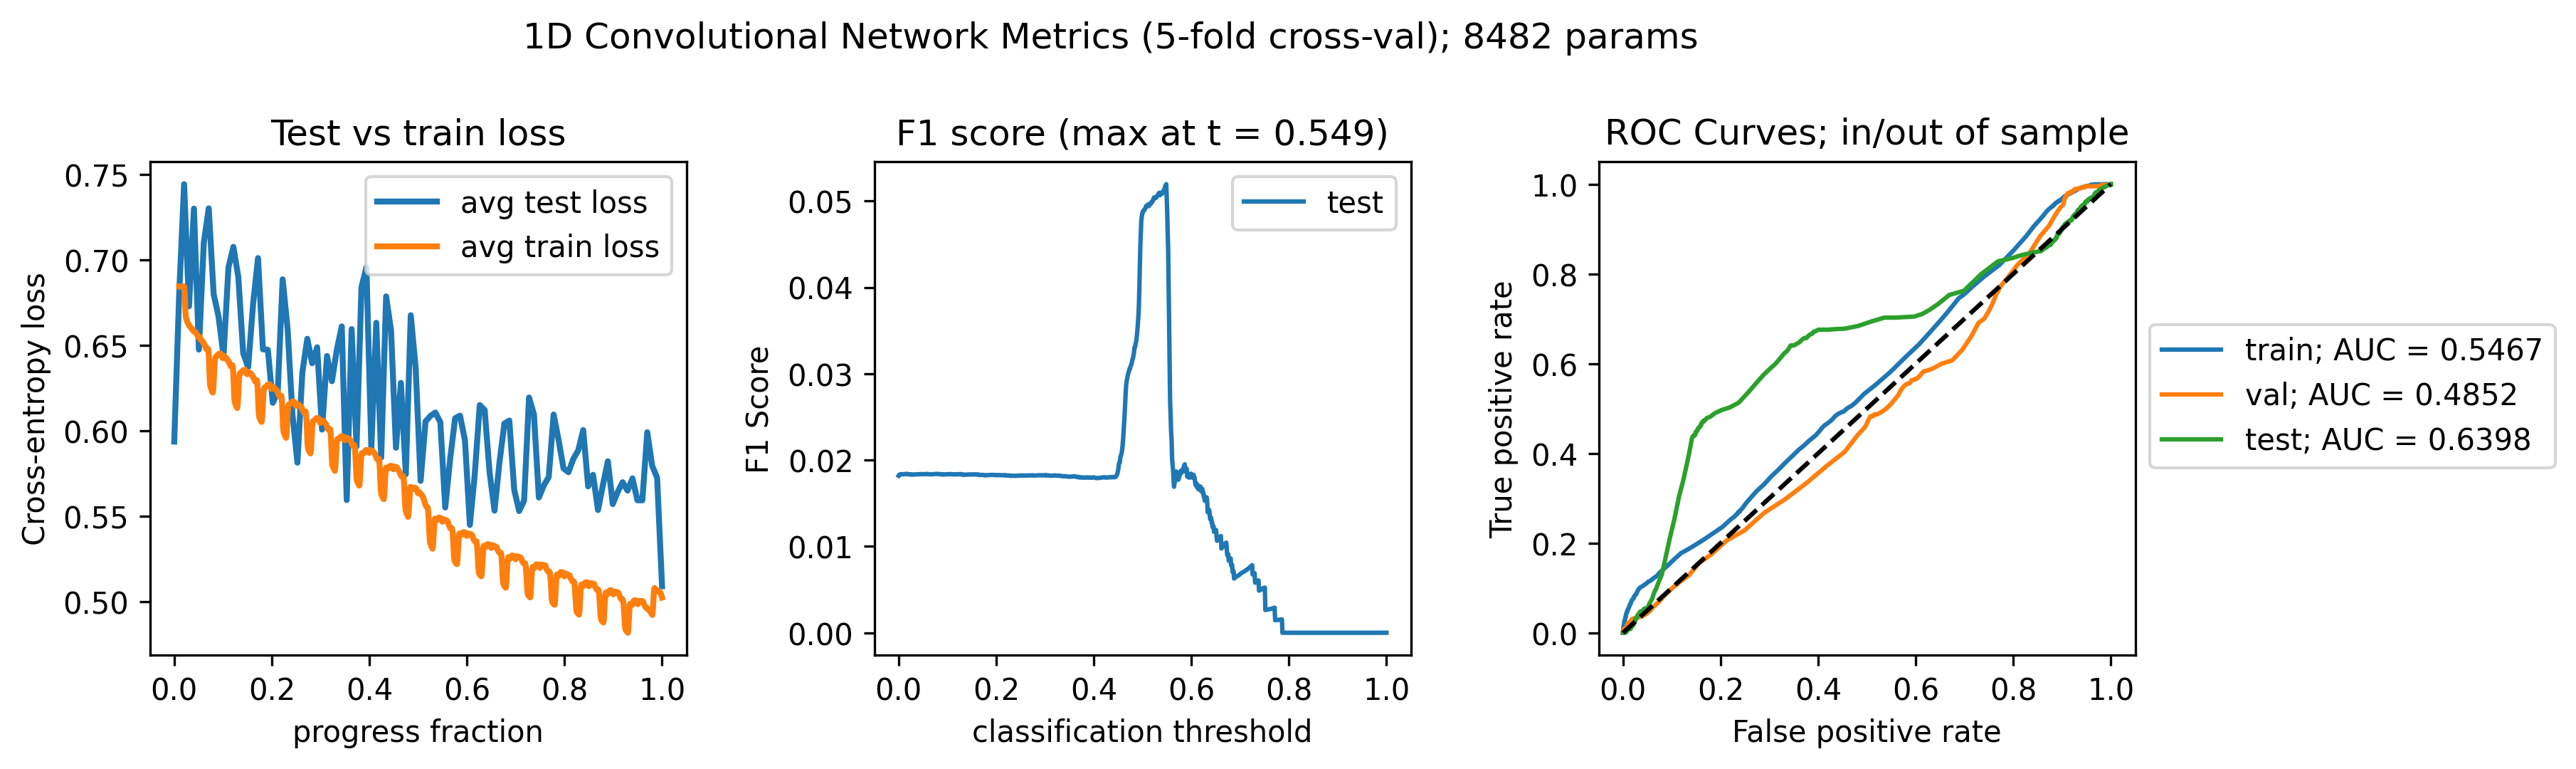

In [6]:
nutils.model_threeplot('Conv1D')

This model does not work at all. Even the train ROC looks terrible! Though the train loss continues to decrease, the test loss plateaus. To get this model comparable with the FFNN would require architecture modification and hyperparameter optimization. This approach probably isn't a good one, since it's also much more computatationally intensive than the better-performing model above. 

Loading 'convNet' from notebook_models/Conv1D/convNet.py


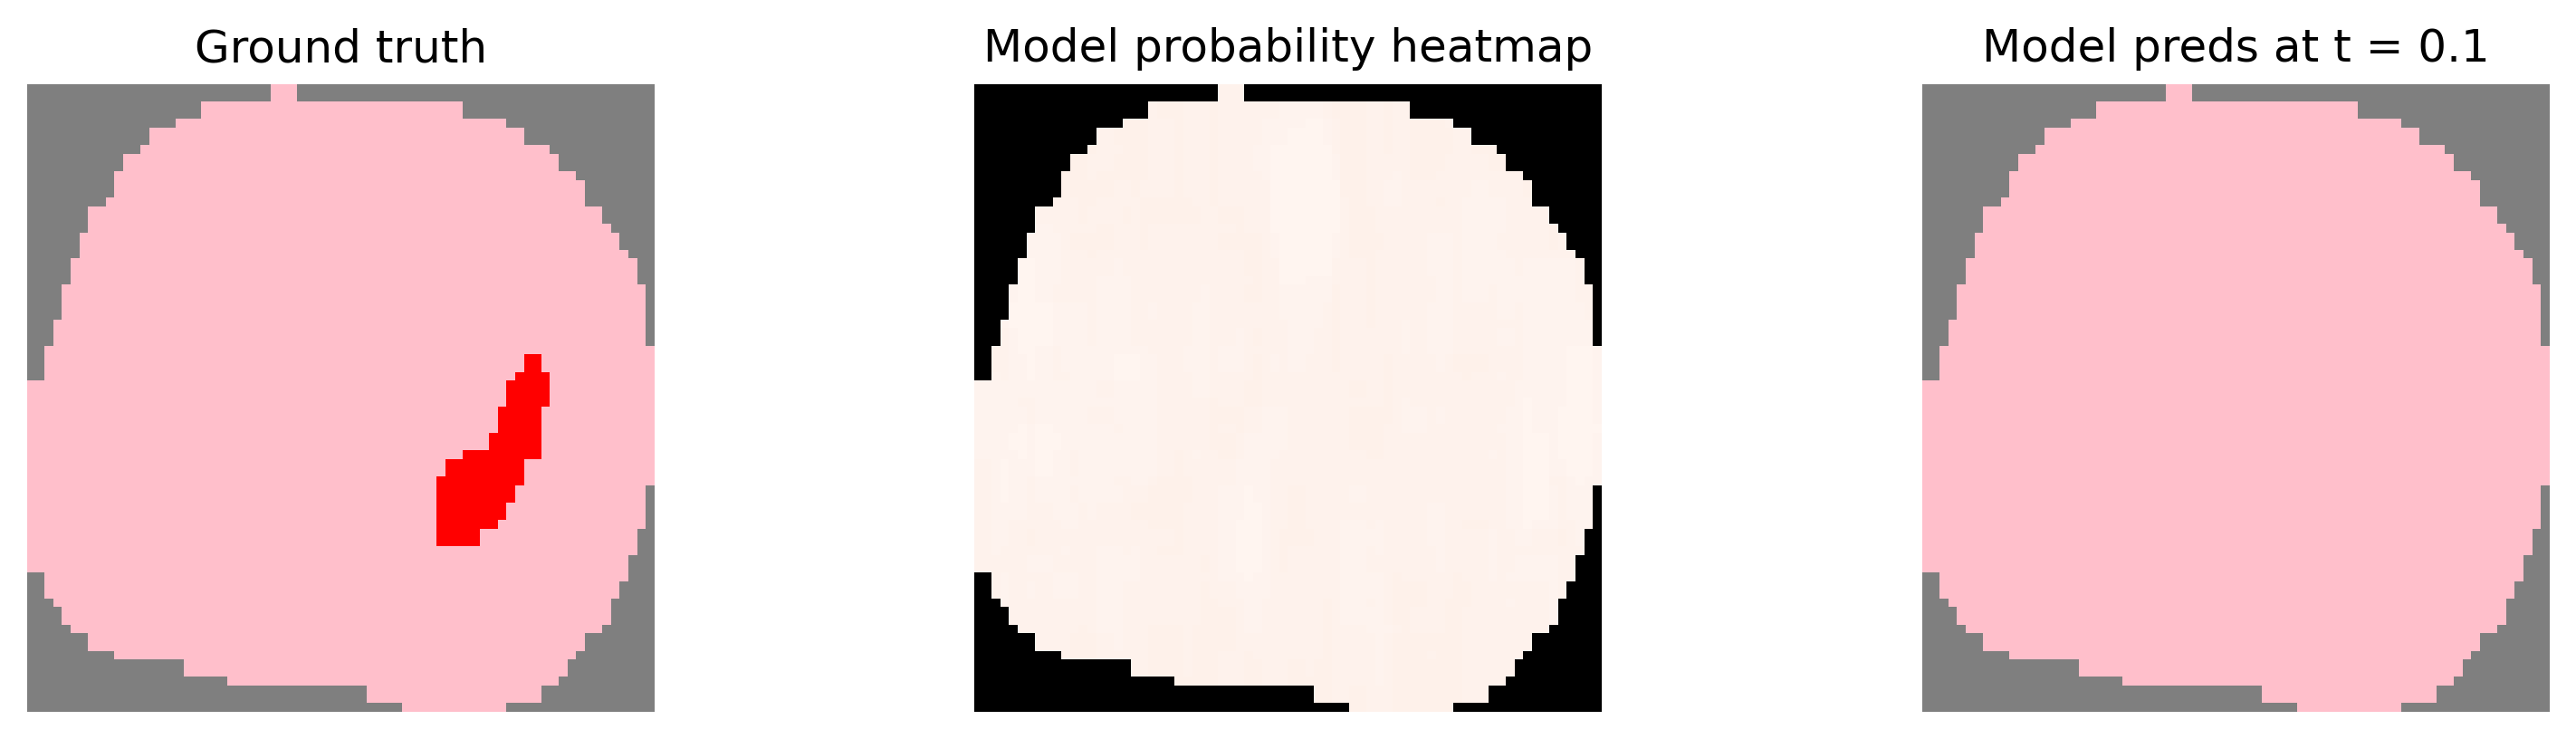

In [7]:
nutils.modelImgCompare('Conv1D',0.1)

## Coordinatized approaches

Now we will treat the spectral data as images with $K$ channels, where $K$ is the number of spectral measurements. The data are arranged in csv format with pixel $x,y$ coordinates which **do not** cover an entire square area. 

To deal with this, we construct a new dataset `PennImageData` as follows. Given a histology slice as a set of rows $(label,x,y,K)$, we compute the min/max values of $x,y$ and embed the label values in a square array. The images are not square: we pad the remaining pixels with label 0 and with spectral values given by the average over spectral data, at each wavelength, for all pixels with label 0 in the given image. Finally, we upsample (interpolate) the image to resolution $72 \times 72$. This padding procedure is designed to help the model avoid looking at the padded pixels. 

This preprocessing procedure results in 112 images. Each image has a label array of shape $(72,72)$ and a data tensor of shape $(39,72,72)$. When we load the data, we can choose to retain only a subset of the spectral data. When the data is batched, it is batched by slices. Note that in principle, since the data has a 3D origin, it is possible that there is minor information leakeage due to correlations between slices in the $z$ direction. This could be avoided by labeling the images by subject and batching by subject. 

While our dataset was small to begin with, it's now even smaller. With a train/test split of 0.8, we only have about 90 training images. This means networks need to be really small--or really well initialized--to have any hope of extracting meaningful features. We will assist the training process by augmenting the dataset with (all) 90 degree rotations of all images. This augmentation is performed independently in the train/test datasets. 

In [8]:
image_config = AttrDict({'input_channels':39, # number of input channels
                         'cross_validate':True, # whether or not to perform K-fold cross validation
                           'rot_augment':True, # whether to rotationally augment the dataset
                           'train_split':0.8, # train/test split for data
                           'n_repeats':1, # times to repeat cross-validation
                           'split_seed':3, # integer seed for validation split (for reproducibility)
                           'batch_size':10}) # batch size for training

### Model outputs and loss functions

The models to follow have inputs of shape $(N_b,39,72,72)$ and outputs of shape $(N_b,2,72,72)$ where $N_b$ is the batch size. 

We'll also be using a slightly different loss criterion. Previously, we had used the class-weighted cross entropy. Here, we will deploy a variation on this called the "focal loss", introduced by Lin et al.

>Lin, Tsung-Yi, et al. "Focal loss for dense object detection." *Proceedings of the IEEE international conference on computer vision.* 2017.

The focal loss is designed for dense object detection, which includes our segmetation task (of identifying dense abnormal regions). Let $p_t$ be the probability $p$ of being in class 1 if the label $y = 1$ and $1-p$ otherwise. The focal loss is defined as:
$$ FL_\gamma(p_t) = -(1-p_t)^\gamma \log(p_t) $$
The focal loss adds to the standard cross-entropy a weighting term with parameter $\gamma$. The purpose of the weight term is to encourage the learning of hard-to-classify examples. This provides another way to compensate for the class imbalance in the data. Here, defining class weights as the inverse proportion of each class in the data, our dataset has weights generally around $w = (1,150)$. In all the computations to follow, we use the focal loss with weighted labels and $\gamma = 10$.

### *Fully convolutional neural network*

The first coordinatized model we will implement is a simple fully-convolutional network. We use 2D convolutional layers with batch normalizations and no fully-connected layers. In the cell below, we specify the setup. 

In [9]:
conv2d_model_config = 'notebook_models/Conv2D/conv2D.py'
image_data_config = 'data_configs/penn_images.py'

model,model_name = fet.load(conv2d_model_config,image_config)
model

Loading 'conv2D' from notebook_models/Conv2D/conv2D.py


Conv2D(
  (conv1): Conv2d(39, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (transition): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
)

The training was done with 5-fold cross-validation; below we configure the model hyperparameters and evaluate its peformance. 

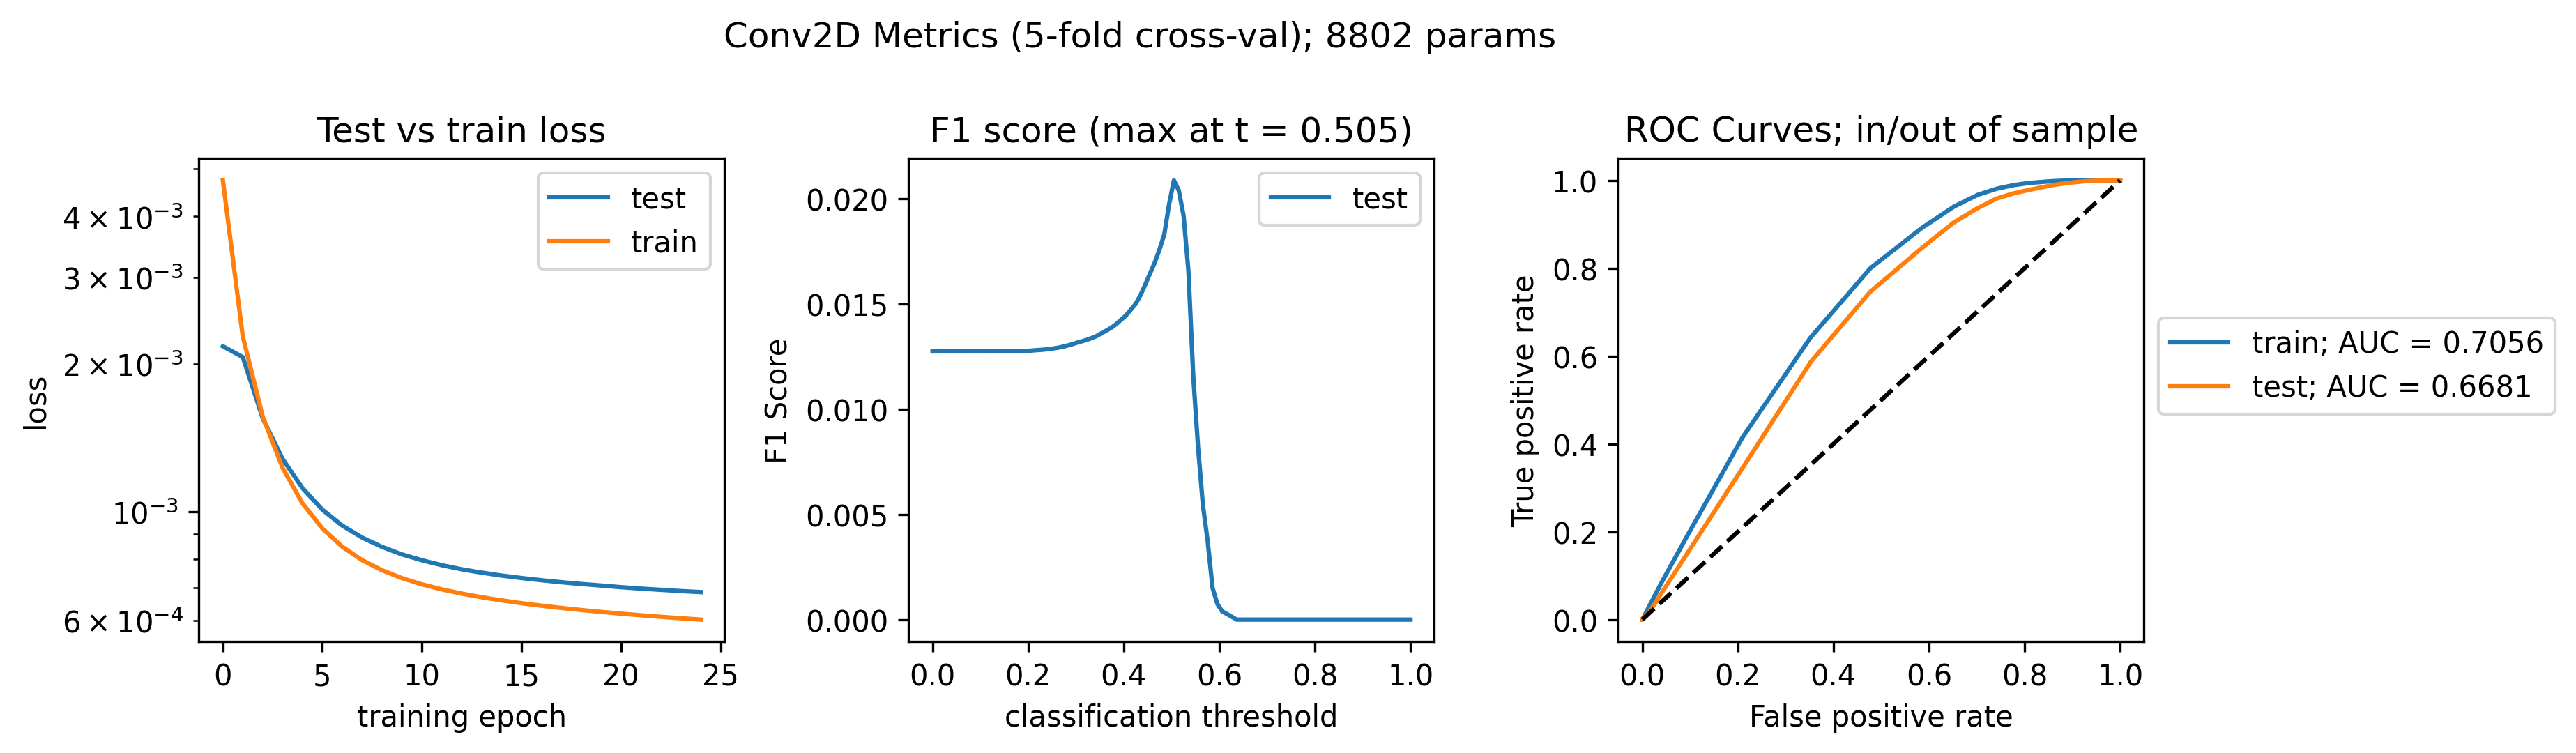

In [10]:
nutils.model_threeplot('Conv2D')

Now we're talking! The model is clearly learning and the ROC curves display some actual segmentation ability. Futhermore, from the training/test loss and the ROC curve profile, the model does not appear to be overfitting. It's not surprising perhaps that the image convolutional network is able to integrate spatial information more effectively. Let's consider this the AUC to beat as we consider more complex models. 

Loading 'conv2D' from notebook_models/Conv2D/conv2D.py
Loading 'penn_images' from data_configs/penn_images.py


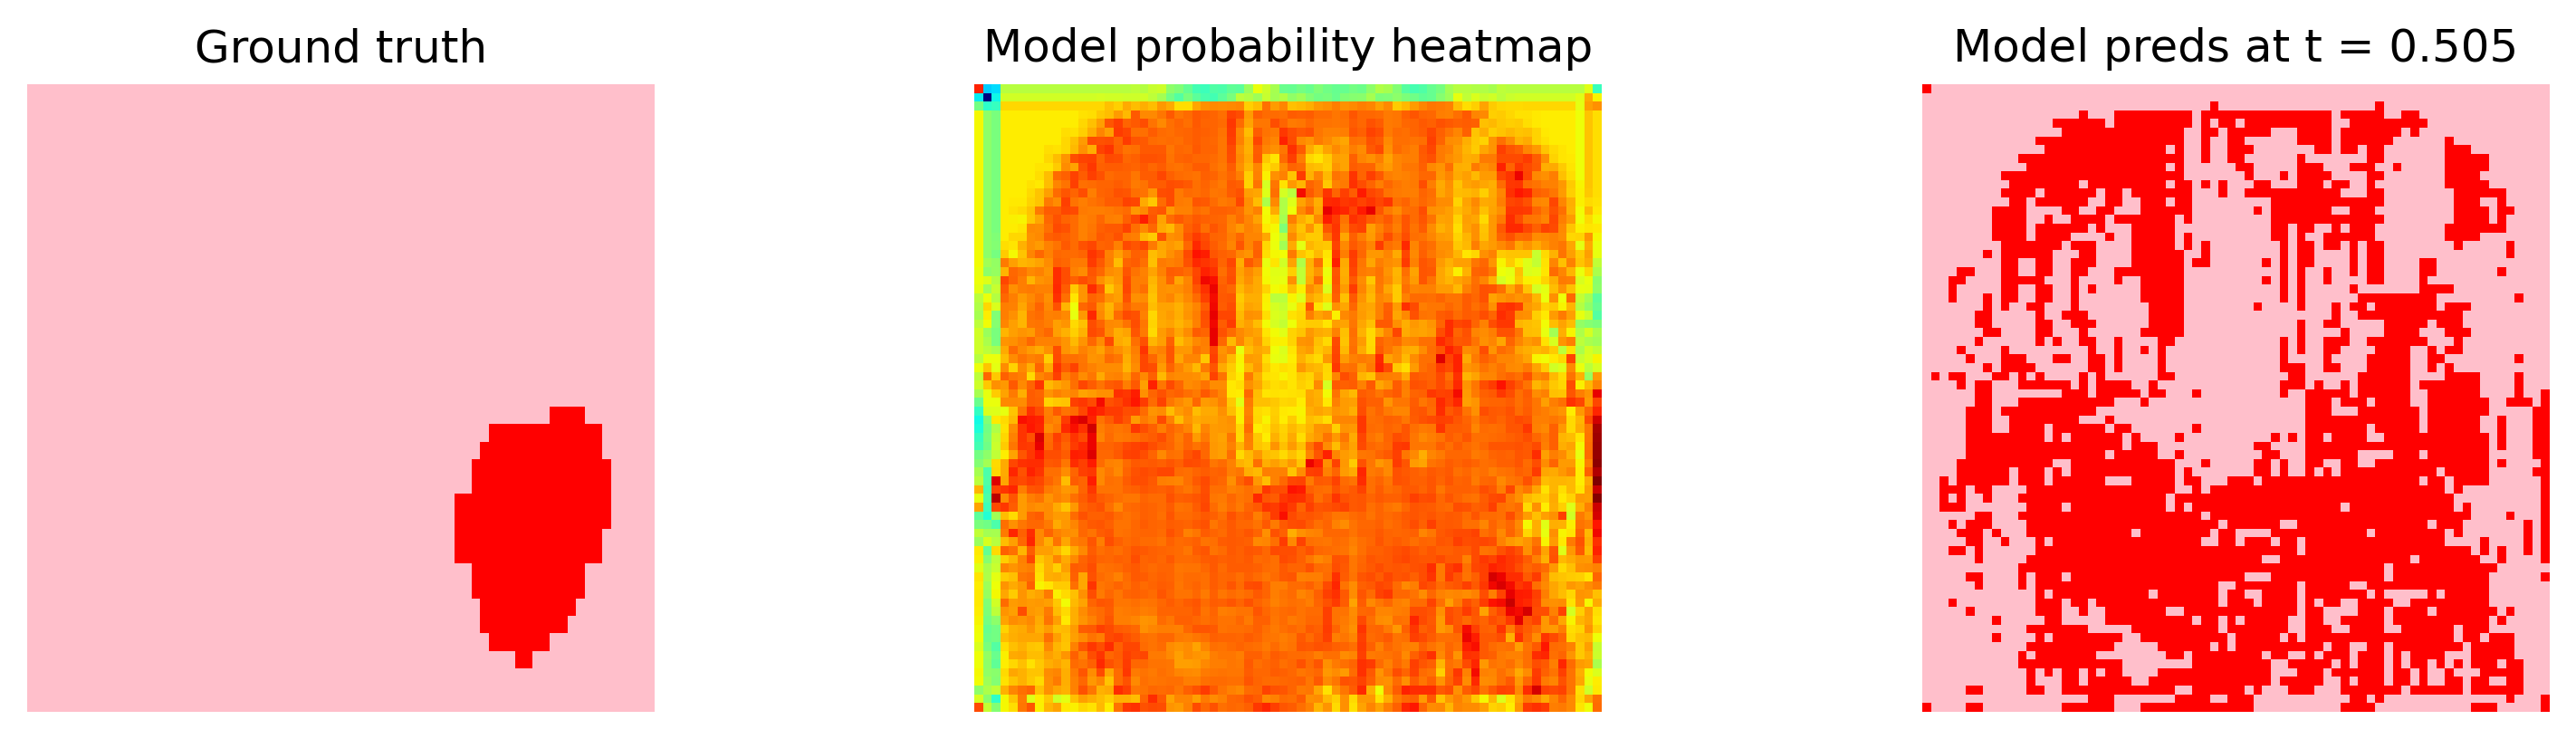

In [11]:
experiment_dir = 'model_experiments/conv2D_allk_crossVal'
optimal_threshold = 0.505

nutils.ImageModelCompare(conv2d_model_config,image_data_config,image_config,experiment_dir,optimal_threshold)

While the AUC is improved from earlier models, it's still not a very good predictor (as evidenced by its performance above!). However, it's at least showing areas of the image which are not expected to show any abnormal growth. If we compare this to the example data above (which is drawn from the exact same histology slice), we can seee that the region the model avoids in the middle, top, we can see that it displays serious intensity at large wavelengths, meaning the gland structure is sparse and not indicative of abnormality. That's good!

### *Fine-tuned models*

It's difficult to build expressive models with so little data. Instead of simply trying to bootstrap our way there, we can do **transfer learning**: downloading pre-trained weights for a given model architecture and using those weights to initialize training. With the hope that the pretrained models have learned relatively universal feature maps, we can leverage a much larger model on our small dataset. 

#### U-net architectures

The task is image segmentation. For many image segmentation tasks, including medical image segmentation, the **U-Net** architecture is commonly employed. 
>Ronneberger, Olaf et al. “U-Net: Convolutional Networks for Biomedical Image Segmentation.” *ArXiv abs/1505.04597* (2015).

U-Net is fundamentally a fully convolutional architecture. It utilizes many skip connections to be able to detect and segment a hierarchy of different-sized features. It is also a transformer-like architecture with an encoder block and a decoder block. The most basic U-Net architecture, from the paper cited above, is shown below. 

<div style="text-align: center;">
<img src="notebook_images/u-net-architecture.png" width="700"/>
</div>

We will use the package `backbones_unet` which includes a long list of pretrained U-net models. Furthermore, the interface allows us to freeze certain layers in training to assist in the fine-tuning task. 

#### ConvNext models

After testing many pretrained models, the model class that seems to perform best on average is the "ConvNext" family. This is likely partially due to the fact that many more familiar models: efficientNet, resNet, etc. are pretrained on the *ImageNet* dataset, designed for image classification. Since we aren't trying to recognize conventional objects, networks trained on this dataset tend not to perform very well for the task at hand. 

The model was introduced after the success of VisionTransformer and Swin-Transformer, attention-based image models that we studied earlier in the course. ConvNext was shown to outperform these models on the *ImageNet* dataset. Furthermore, the architecture of ConvNext () makes it especially appropriate for image segmentation tasks.

>Liu, Zhuang et al. “A ConvNet for the 2020s.” *2022 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)* (2022).

The authors begin with a ResNet architecture and modify it with the goal of integrating design choices made in the highly successful transformer models. In particular, this involves "inverted bottlenecks": blocks where the width of hidden layers exceeds by a multiplicative factor the dimensions of the input and output channels. Compared to SwinTransformer, ConvNext uses a large-kernel convolutional layer instead of a multi-head attention block. The image below shows the differences between SwinTransformer, ResNet, and ConvNext blocks. There are a number of micro choices: activation functions, residual connections, layer normalizations, that are included in the ConvNext design. 

<div style="text-align: center;">
<img src="notebook_images/convnext_arch.png" width="500"/>
</div>

#### Fine tuning experiment 1

In [16]:
pretrained_models = ['convnext_tiny_hnf','convnext_pico_ols','convnext_nano_ols','convnext_nano','convnext_femto','convnext_femto_ols']

MODEL_NAME = 'convnext_pico_ols'

pretrained_config = AttrDict({'backbone':MODEL_NAME,'input_channels':39})
pretrained_model_config = osp.join('notebook_models','pretrained_unets','pretrained_unet.py')

model,model_name = fet.load(pretrained_model_config,pretrained_config)
model

Loading 'pretrained_unet' from notebook_models/pretrained_unets/pretrained_unet.py


Unet(
  (encoder): FeatureListNet(
    (stem_0): Conv2d(39, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (stem_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (stem_2): LayerNorm2d((64,), eps=1e-06, elementwise_affine=True)
    (stages_0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
          (norm): LayerNorm2d((64,), eps=1e-06, elementwise_affine=True)
          (mlp): ConvMlp(
            (fc1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
            (norm): Identity()
            (act): GELU()
            (drop): Dropout(p=0.0, inplace=False)
            (fc2): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), gro

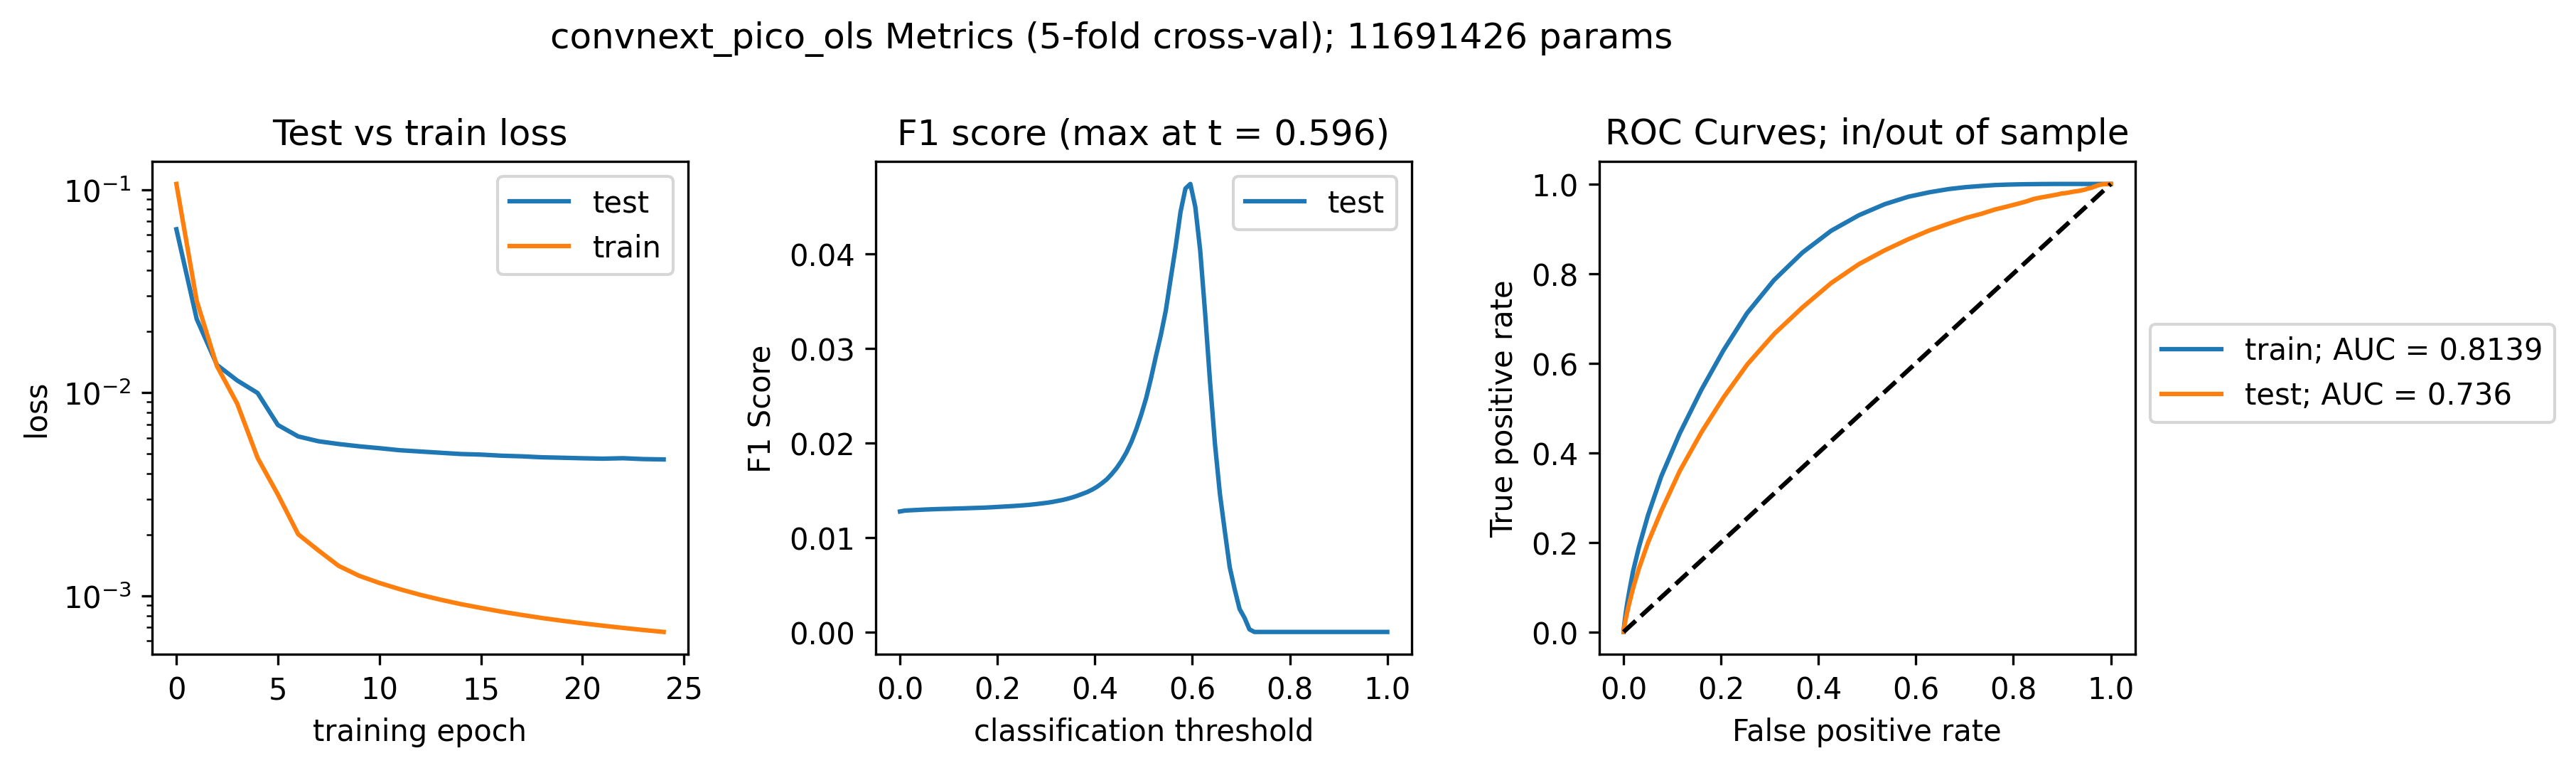

In [17]:
nutils.model_threeplot(model_name)

Loading 'pretrained_unet' from notebook_models/pretrained_unets/pretrained_unet.py
Loading 'penn_images' from data_configs/penn_images.py


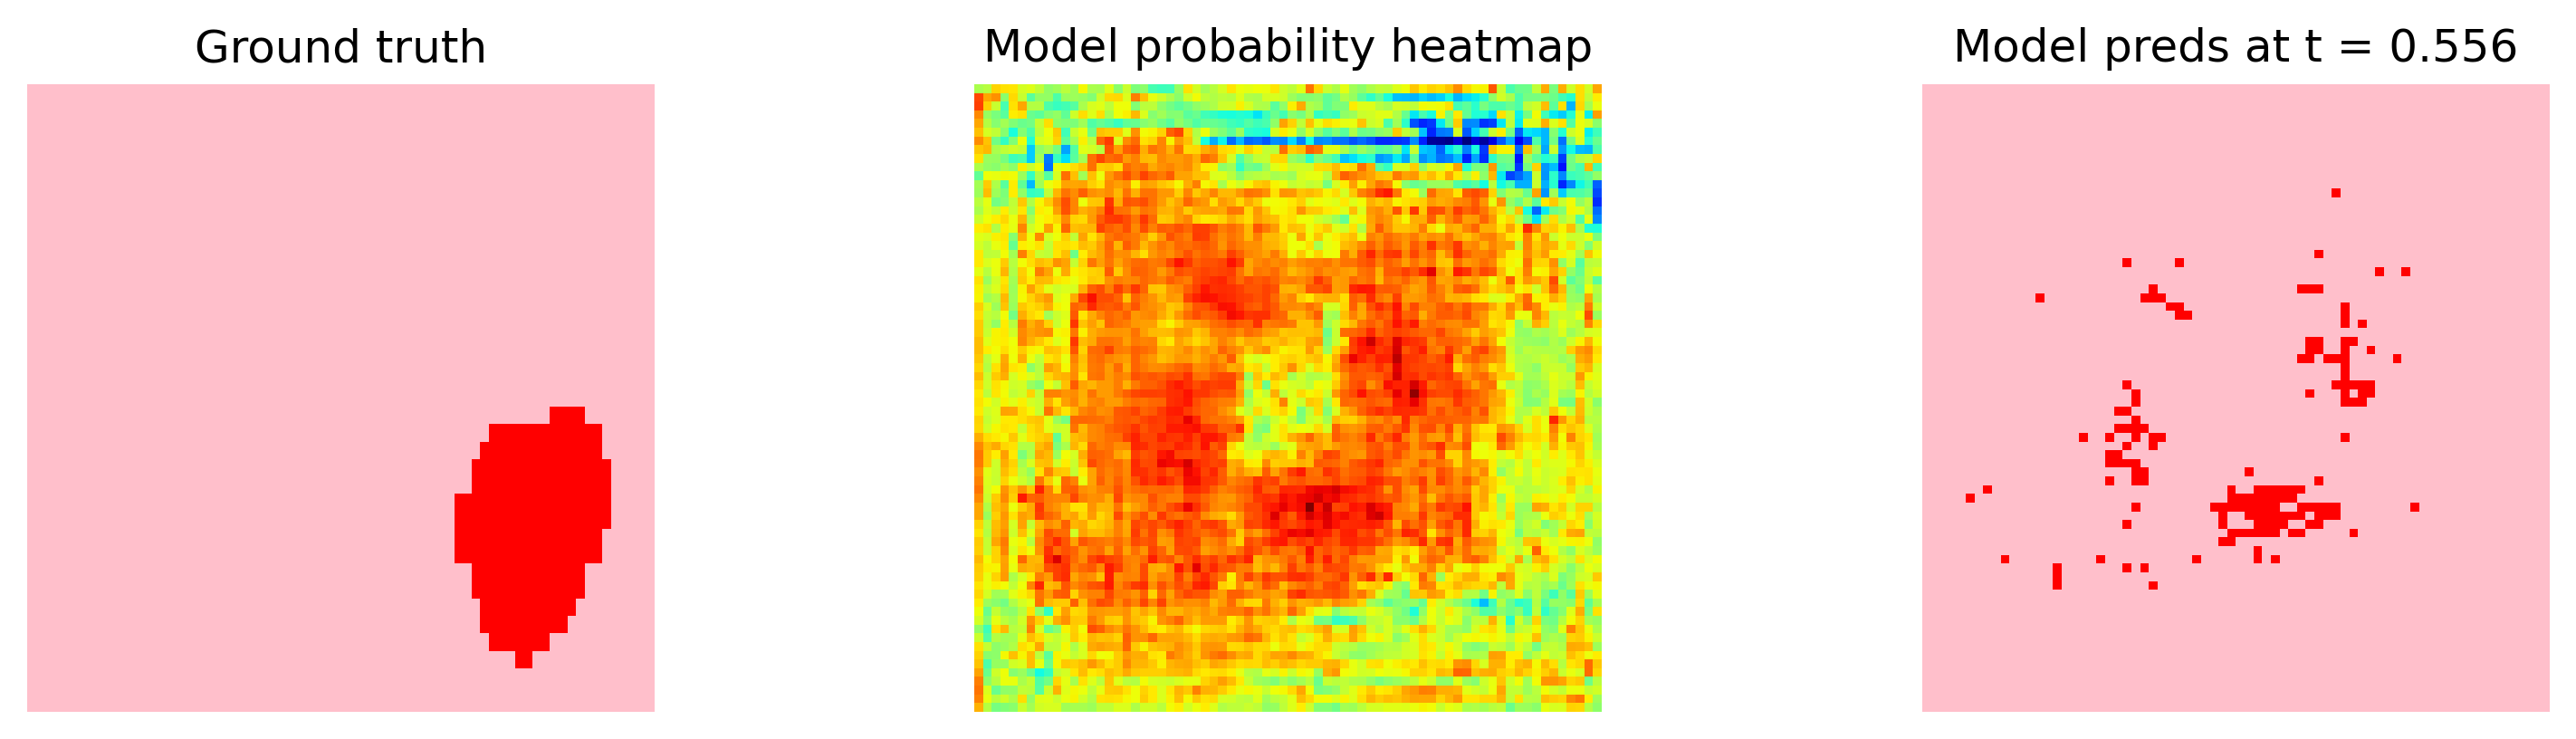

In [18]:
experiment_dir = 'model_experiments/pretrained_model_comparison_allk_crossVal'
optimal_threshold = 0.556
image_config['backbone'] = model_name

nutils.ImageModelCompare(pretrained_model_config,image_data_config,image_config,experiment_dir,optimal_threshold)

### Fine-tuning experiment 2: frozen encoder

We saw that U-net architectures resemble transformers with an encoder and a decoder. Above, we loaded the pretrained model and trained all weights for 20 epochs. Here, we conduct a slightly altered experiement: we train for 50 epochs with the zeroth layer of the encoder **frozen**: we specify that these parameters are untrainable. 

The result is that the model retains its most basic feature creation layer. By freezing this layer, we focus training on higher-level features and hope that the model can more precisely learn from the training data. We also train the models for twice as many epochs in the hope that performance won't saturate given the large number of parameters. 

In [22]:
pretrained_models = ['convnext_tiny_hnf','convnext_pico_ols','convnext_nano_ols','convnext_nano','convnext_femto','convnext_femto_ols']

MODEL_NAME = 'convnext_pico_ols'

pretrained_config = AttrDict({'backbone':MODEL_NAME,'input_channels':39})
pretrained_model_config = osp.join('notebook_models','pretrained_unets','pretrained_unet.py')

model,model_name = fet.load(pretrained_model_config,pretrained_config)
model

Loading 'pretrained_unet' from notebook_models/pretrained_unets/pretrained_unet.py


Unet(
  (encoder): FeatureListNet(
    (stem_0): Conv2d(39, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (stem_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (stem_2): LayerNorm2d((64,), eps=1e-06, elementwise_affine=True)
    (stages_0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
          (norm): LayerNorm2d((64,), eps=1e-06, elementwise_affine=True)
          (mlp): ConvMlp(
            (fc1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
            (norm): Identity()
            (act): GELU()
            (drop): Dropout(p=0.0, inplace=False)
            (fc2): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), gro

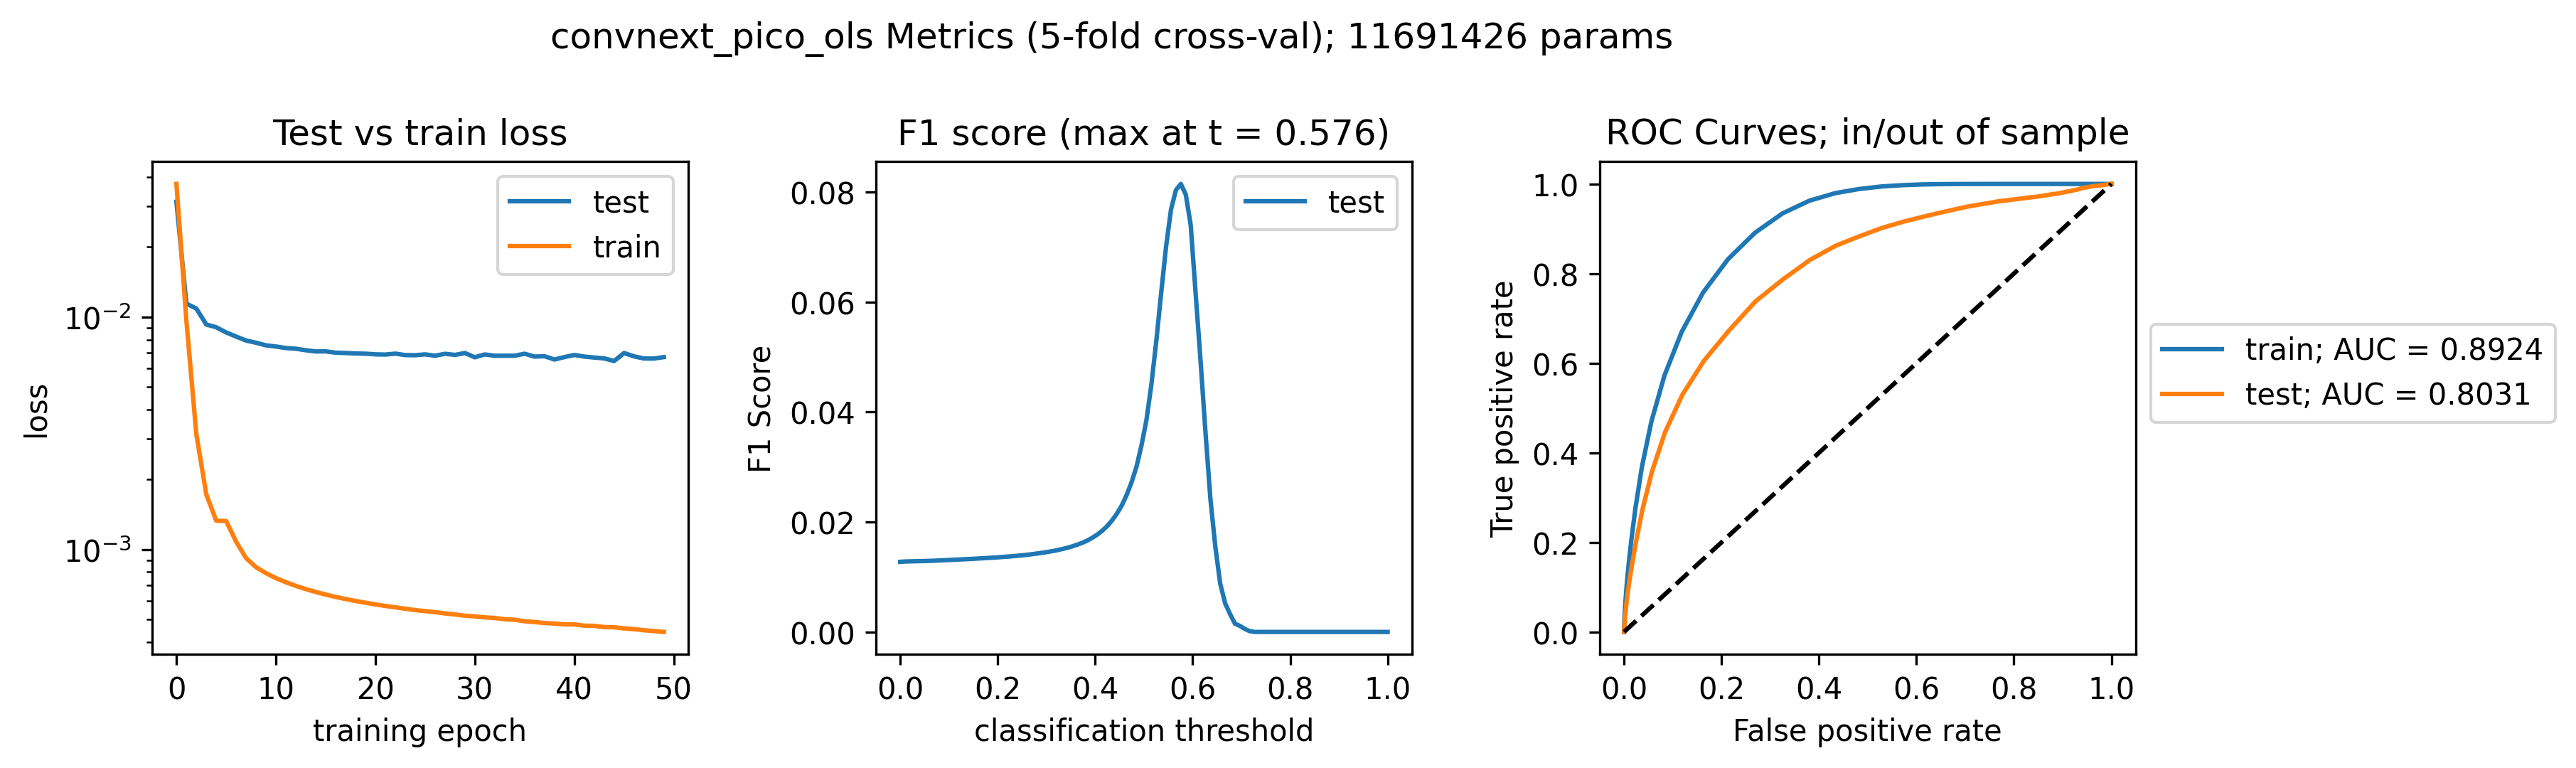

In [23]:
nutils.model_threeplot(model_name,metric_filename = 'encoderfreeze_metrics.h5')

Loading 'pretrained_unet' from notebook_models/pretrained_unets/pretrained_unet.py
Loading 'penn_images' from data_configs/penn_images.py


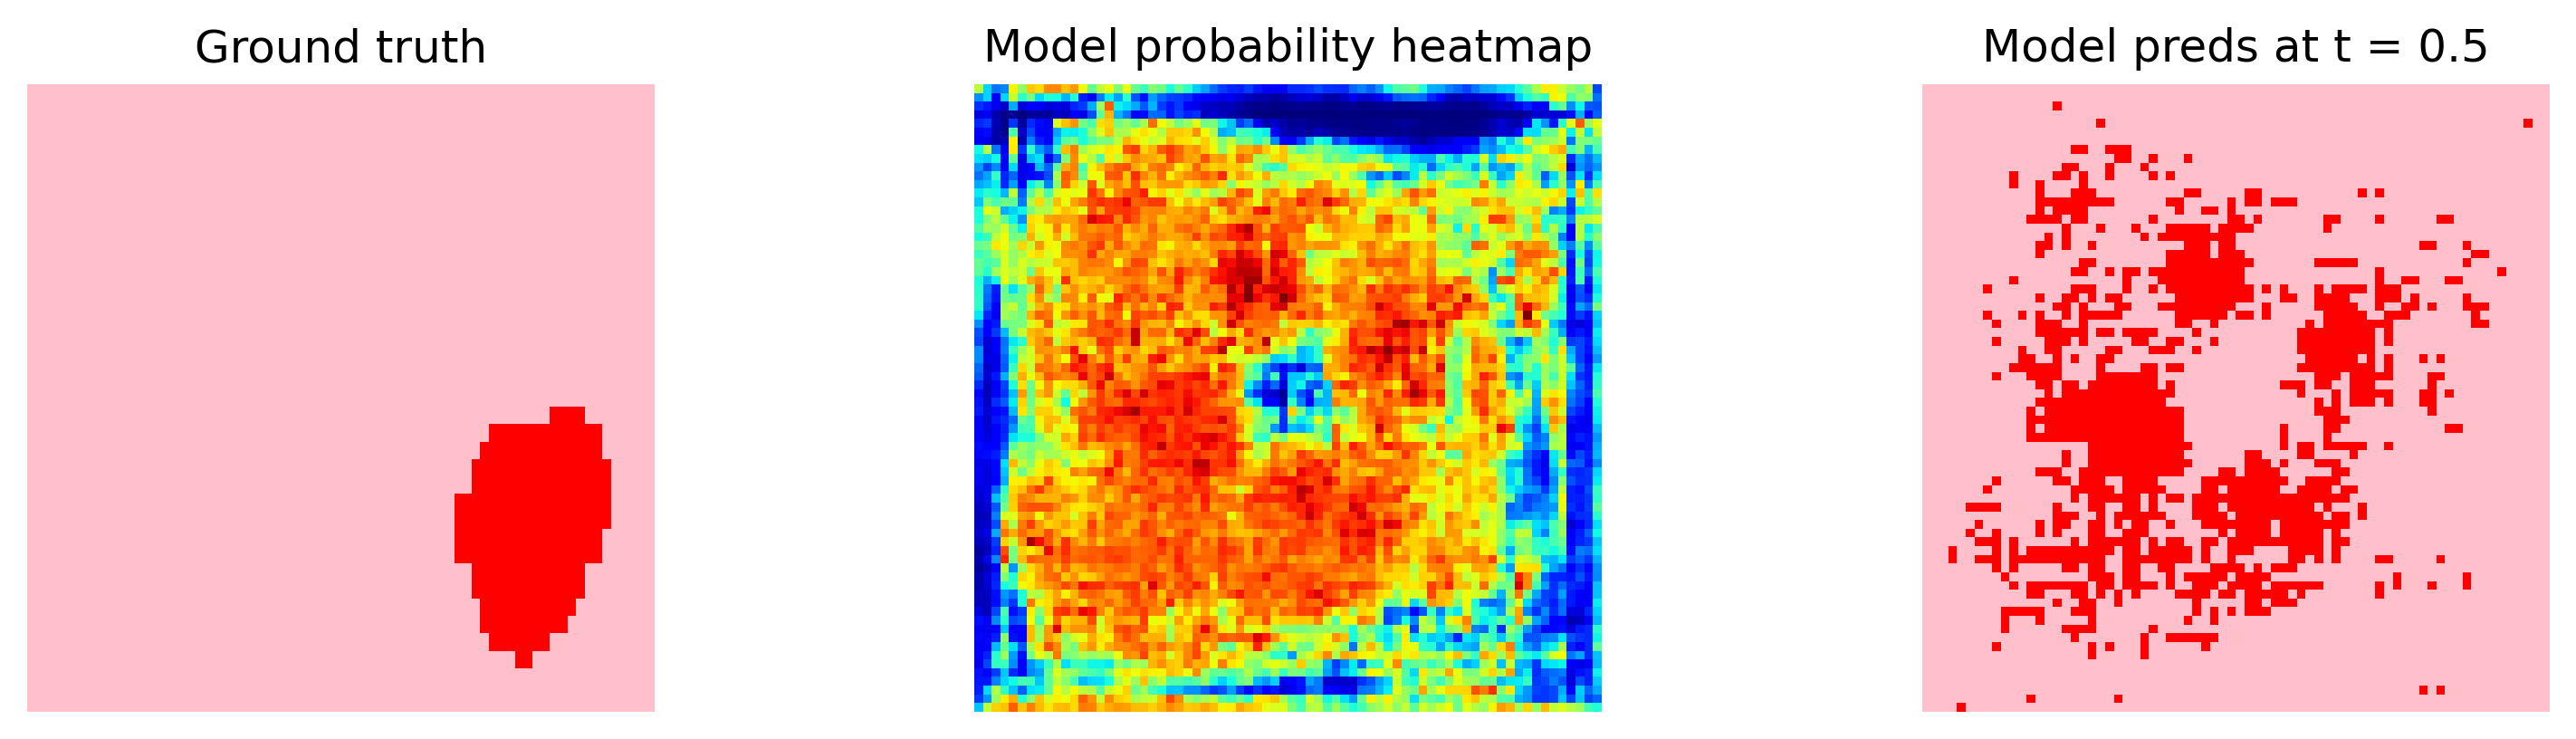

In [24]:
experiment_dir = 'model_experiments/model_comparison_allk_crossVal_encoderFreeze0'
optimal_threshold = 0.5
image_config['backbone'] = model_name

nutils.ImageModelCompare(pretrained_model_config,image_data_config,image_config,experiment_dir,optimal_threshold)

There is clearly more work to be done. With fine-tuning, we can experiment with freezing different encoder layers, training epochs, and loss function hyperparameters. 

## Conclusion

This project is ongoing. The task is difficult and the dataset is small, which makes it very difficult. Here are some ideas for ways to improve the model performance and for other types of architectures that might work well for the task at hand: 

* Optimize loss function parameters: for some set of models, try a number of values of the focal loss parameter $\gamma$ and compare how they affect training outcomes.
* Equivariant (steerable) CNNs: since the dataset has no inherent direction, perhaps a 2d $SO(2)$ steerable CNN would improve performance over a regular CNN.
* Better masking for CNNs: instead of padding the image by pixels, models could take in as data a binary mask denoting where non-padded data-cells are and be hardcoded to avoid these cells. This presents a challenge for sliding window CNNs.
* Zoom instead of pad: instead of padding the image, zoom in far enough to have a square window full of data and train the same models as above. Reducing the padding reduces the data imbalance and removes spurious inflation of the ROC curves. This can additionally be regarded as scale-based data augmentation.
* Many-channel architectures: many of the pretrained models we tried here are designed for 1 or 3 channel images. When we feed a many-channel image into the model, the weights at the three native channels are copied to cover all input channels. However, our data is distinct at each channel, so copying these weights might not be a good idea. One solution might be to freeze deeper levels in the encoder, so that the early feature generation layers are able to learn new aspects of the differences between wavelength channels. 
* **Attention-based architectures**: instead of assembling pixels in a square image suitable for CNNs, we can batch all data by image sector and feed it into an attention-based model. We can devise local, equivariant attention which weights not only spatial information but also feature information, focusing on the most important part of the spectral data.

